In [17]:
def GetMidiSlices(fileName):
    midiArray=[]
    HopSize=hopLength/sr
    timeTracker=0.0
    totalTimeTracker=0.0
    MemoryArray=np.zeros(128)
    lasttime=0;
    bpm=60
    for msg in mido.MidiFile(fileName+'.mid'):
        if not msg.is_meta:
            totalTimeTracker+=msg.time
            nextEventTime=lasttime+msg.time
            while nextEventTime> timeTracker + HopSize:
                MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
                midiArray.append(MemoryArray.copy())
                timeTracker += HopSize;
            if msg.type=='note_on':
                MemoryArray[msg.note]+=1.0;
            elif msg.type=='note_off':
                MemoryArray[msg.note]-=1.0;
            if(timeTracker+msg.time >= timeTracker + HopSize):
                MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
                midiArray.append(MemoryArray.copy())
                timeTracker += HopSize
            lasttime += msg.time
        else:
            if(msg.type == 'set_tempo'):
                bpm=60000000/msg.tempo
    return np.array(midiArray)

def CreateSeqeunce(dataArray,SeqeunceLen):
    OutArray=[]
    for i in range(np.int(np.floor(dataArray.shape[0]/SeqeunceLen))):
        tempArray=[]
        for j in range(SeqeunceLen):
            tempArray.append(dataArray[(i*SeqeunceLen)+j])
        OutArray.append(tempArray)
    return np.array(OutArray)

def generateAudio(stringInput,fileName):
    print("generating audio and Spectrum image")
    MainMidiTest=CreateSeqeunce(GetMidiSlices(stringInput),SequenceLength)
    tensor_x_test = torch.stack([torch.Tensor(i) for i in MainMidiTest])
    #tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)
    testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
    TestLoader = utils.DataLoader(testDataSet,batch_size=BatchSize) # create your dataloader
    model.eval()
    outputArray=[]
    for data, labels in TestLoader:
        print(data.shape)
        if data.shape[0] < BatchSize:
            zeros = torch.zeros((BatchSize-data.shape[0],SequenceLength,128))
            data=torch.cat((data,zeros))
        print(data.shape)
        with torch.no_grad():
            data, labels = data.to(device), labels.to(device)
            output,_,_ = model.forward(data,data.shape[0])
            for i in range(data.shape[0]):
                for j in range(SequenceLength):
                    outputArray.append(output[i,j,:].cpu().numpy())
            #outputArray.append(output[0].cpu().numpy())
    outputArray=np.array(outputArray)
    print(outputArray.shape)
    transformedArray=[]
    for elem in outputArray:
        a=np.array(np.int((n_fft/2+1)) *[1+1j])
        a.real=elem[:np.int(n_fft/2+1)]
        a.imag=elem[np.int(n_fft/2+1):]
        transformedArray.append(a)
    transformedArray=np.array(transformedArray).T
    Y_infered2 = librosa.istft(transformedArray,hop_length=hopLength) 
    plt.figure(figsize=(20,10))
    
    librosa.display.specshow(librosa.amplitude_to_db(transformedArray.real,
                                                      ref=np.max),
                              y_axis='log', x_axis='time')
    plt.title('Power spectrogram  ' + str(Counter) )
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

    #plt.show();
    plt.savefig(fileName+'.png')
    #librosa.output.write_wav(fileName+'.wav', Y_infered2, sr)
    plt.close();

In [2]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim
import torch.utils.data as utils

import torch.nn.functional as F
from torch import nn
import torch


In [3]:
fielName='4Beats2MelLong5'
windowSize=50
n_fft=2048
hopLength=1024
SequenceLength = 25 
BatchSize=128

In [4]:
y, sr = librosa.load(fielName+'.wav')
D = np.array(librosa.stft(y,n_fft=n_fft,hop_length=hopLength))

MidiArray = GetMidiSlices(fielName)
minLength = min(MidiArray.shape[0],D.T.shape[0])
MidiArray=MidiArray[:minLength];
D_data=np.array([np.append(np.float32(elem.real), np.float32(elem.imag)) for elem in D.T[:minLength]])


MidiArray=CreateSeqeunce(MidiArray,SequenceLength)
D_data=CreateSeqeunce(D_data,SequenceLength)

In [5]:
print(D.shape)
Y_SeqeuenceLength = librosa.istft(D[:SequenceLength],hop_length=hopLength)
ipd.Audio(Y_SeqeuenceLength,rate=sr);


(1025, 53317)


In [6]:
del y
del D

In [7]:
print(MidiArray.shape,D_data.shape)
print(MidiArray.dtype,D_data.dtype)

(2132, 25, 128) (2132, 25, 2050)
float64 float32


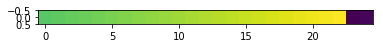

In [8]:
plt.imshow(MidiArray[6,:,127:].T) # visulizing the bea

In [9]:
tensor_x = torch.stack([torch.Tensor(i) for i in MidiArray]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)])
print(tensor_x.shape,tensor_y.shape)

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset

train_size = int(0.8 * len(my_dataset))
test_size = len(my_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])

my_dataloader = utils.DataLoader(train_dataset,batch_size=BatchSize,shuffle=True) # create your dataloader
my_validationloader = utils.DataLoader(test_dataset,batch_size=BatchSize,shuffle=True) # create your dataloader
print(len(my_dataloader),len(my_validationloader))
my_testloader = utils.DataLoader(my_dataset) # create your dataloader

torch.Size([2132, 25, 128]) torch.Size([2132, 25, 2050])
14 4


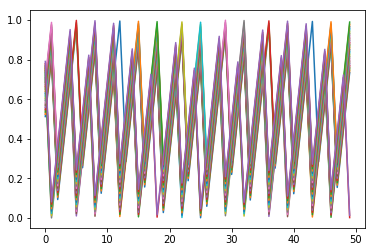

In [10]:
plt.plot(tensor_x.numpy()[50:100,:,127])
plt.show()

In [23]:
## Solution

class LSTMNetwork(nn.Module):
    def __init__(self):
        super(LSTMNetwork,self).__init__()
        # Defining the layers, 128, 64, 10 units each
        
        #self.num_layers=1
        self.hiddenLayerSize=1024
        #self.word_lstm_init_h = nn.Parameter(torch.zeros(self.num_layers, BatchSize, self.hiddenLayerSize).type(torch.FloatTensor), requires_grad=True)
        #self.word_lstm_init_c = nn.Parameter(torch.zeros(self.num_layers, BatchSize, self.hiddenLayerSize).type(torch.FloatTensor), requires_grad=True)
        #self.word_lstm_init_h.cuda()
        #self.word_lstm_init_c.cuda()
        #self.fc0 = nn.LSTM(128, self.hiddenLayerSize,num_layers=self.num_layers,batch_first=True)
       
        self.fc0 = nn.Linear(128, self.hiddenLayerSize)
        self.fc1 = nn.Linear(self.hiddenLayerSize, self.hiddenLayerSize*2)
        self.fc2 = nn.Linear(self.hiddenLayerSize*2, n_fft+2)
        #self.h0 = torch.zeros(self.num_layers, 1, (n_fft+2*2)).cuda() # 2 for bidirection 
        #self.c0 = torch.zeros(self.num_layers, 1, (n_fft+2*2)).cuda()
        

    def forward(self, x, ActualBatchSize):
        ''' Forward pass through the network, returns the output logits '''
        #self.h0=h0
        #self.c0=c0 
        #x=x.view(SequenceLength,ActualBatchSize,128)
        #x,hidden = self.lstm(x,(self.word_lstm_init_h,self.word_lstm_init_c)) #(self.h0,self.c0)
        
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return x,0,0



In [24]:
##Reset
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMNetwork()
print(model)
model.train()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05,momentum=0.9)
criterion = nn.MSELoss()

Counter=0;
LossOverEpoch=[]
EvalLoss=[]

LSTMNetwork(
  (fc0): Linear(in_features=128, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2050, bias=True)
)


In [ ]:
epochs = 2500
for i in range(epochs):
    running_loss = 0
    model.train()
    originalHidden=0
    hidden=0
    for data, labels in my_dataloader:
        #print(data.shape)
        if data.shape[0] != BatchSize:
            #pass
            continue;
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()    
        logits,hidden,originalHidden = model(data,data.shape[0])
        #print(logits.shape)
        loss =criterion(logits,labels) #.permute(1,0,2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval();
    #print(originalHidden[0,0,0],hidden[0][0,0,0])
    evalLossNum=0
    #generateAudio('4Beats2Mel','./generatedData3/'+str(Counter))
    for data, labels in my_validationloader:
        if data.shape[0] != BatchSize:
            #pass
            continue;
        data, labels = data.to(device), labels.to(device)
        pred,hidden,_ = model(data,data.shape[0])  
        loss = criterion(pred,labels)#.permute(1,0,2)
        evalLossNum += loss.item()
    LossOverEpoch.append(running_loss/len(my_dataloader))
    EvalLoss.append(evalLossNum/len(my_validationloader))
    print(str(f"Training loss: {running_loss/len(my_dataloader)}" +"   "+ str(Counter))+"  "+str(evalLossNum/len(my_validationloader)))
    Counter+=1

Training loss: 1.5967233606747218   0  1.1943175196647644
Training loss: 1.5586904968534196   1  1.1996497809886932
Training loss: 1.5349037732396806   2  1.1877082288265228
Training loss: 1.5148061428751265   3  1.179939866065979
Training loss: 1.4894642404147558   4  1.1146298348903656
Training loss: 1.4631456903048925   5  1.1669538021087646
Training loss: 1.467156069619315   6  1.1263677179813385
Training loss: 1.4483717935425895   7  1.1084169149398804
Training loss: 1.4422283342906408   8  1.1450850665569305
Training loss: 1.4420695815767561   9  1.1279402077198029
Training loss: 1.434554636478424   10  1.0948781669139862
Training loss: 1.4498973659106664   11  1.1098737716674805
Training loss: 1.4363704238619124   12  1.1225407123565674
Training loss: 1.424544291836875   13  1.109272986650467
Training loss: 1.4304825919015067   14  1.1112276315689087
Training loss: 1.4369439908436366   15  1.098671317100525
Training loss: 1.4303772960390364   16  1.105737566947937
Training loss:

Training loss: 1.162064186164311   140  0.9366197884082794
Training loss: 1.1514910204069955   141  0.9651192724704742
Training loss: 1.1659173965454102   142  0.9314466118812561
Training loss: 1.1614309889929635   143  0.9073417484760284
Training loss: 1.163873314857483   144  0.9755747616291046
Training loss: 1.1574561425617762   145  0.9417266249656677
Training loss: 1.157548955508641   146  0.9317923188209534
Training loss: 1.1698097501482283   147  0.9062581956386566
Training loss: 1.156965093953269   148  0.8822821974754333
Training loss: 1.160595680986132   149  0.9185265004634857
Training loss: 1.1456435833658491   150  0.8945097625255585
Training loss: 1.1486323475837708   151  0.9542069435119629
Training loss: 1.1495436940874373   152  0.9333077073097229
Training loss: 1.151583296912057   153  0.9142556488513947
Training loss: 1.1548954844474792   154  0.9228047132492065
Training loss: 1.146565590585981   155  0.88870769739151
Training loss: 1.1408706733158656   156  0.925194

Training loss: 0.8934222374643598   278  0.7107773423194885
Training loss: 0.8938259141785758   279  0.7081173956394196
Training loss: 0.8967540775026593   280  0.736974224448204
Training loss: 0.8860942891665867   281  0.7167745232582092
Training loss: 0.8814406650406974   282  0.7172767221927643
Training loss: 0.8802767268248967   283  0.6977091133594513
Training loss: 0.8833547106810978   284  0.7068128734827042
Training loss: 0.887615293264389   285  0.7052132040262222
Training loss: 0.8881429731845856   286  0.7052008509635925
Training loss: 0.8895553009850639   287  0.6994018256664276
Training loss: 0.8728485448019845   288  0.6965826600790024
Training loss: 0.8774828059332711   289  0.7184227854013443
Training loss: 0.874030236686979   290  0.7120390981435776
Training loss: 0.8806318087237222   291  0.6869942545890808
Training loss: 0.8793765263898032   292  0.700560599565506
Training loss: 0.8785394898482731   293  0.6878727227449417
Training loss: 0.8700269290379116   294  0.7

Training loss: 0.7479022783892495   416  0.6055284738540649
Training loss: 0.7457504655633654   417  0.6022209972143173
Training loss: 0.7504739378179822   418  0.6153638511896133
Training loss: 0.7595745367663247   419  0.595868855714798
Training loss: 0.7502173100199018   420  0.6071660071611404
Training loss: 0.7576921241624015   421  0.6026327461004257
Training loss: 0.7514404441629138   422  0.5999505370855331
Training loss: 0.7506821538720813   423  0.5967507511377335
Training loss: 0.7442044786044529   424  0.6155674457550049
Training loss: 0.7398228475025722   425  0.5882350206375122
Training loss: 0.7398256531783513   426  0.603010892868042
Training loss: 0.7386456685406821   427  0.5985923707485199
Training loss: 0.7440601416996547   428  0.6086777895689011
Training loss: 0.7433668502739498   429  0.5860339552164078
Training loss: 0.735123119183949   430  0.5897344201803207
Training loss: 0.737074979713985   431  0.5921019911766052
Training loss: 0.7395054272242955   432  0.5

Training loss: 0.6768895089626312   554  0.55685955286026
Training loss: 0.6814416774681636   555  0.559089258313179
Training loss: 0.6778334294046674   556  0.5459938198328018
Training loss: 0.6786941800798688   557  0.5314177572727203
Training loss: 0.6731986999511719   558  0.5556741058826447
Training loss: 0.6813970804214478   559  0.542524591088295
Training loss: 0.6773644089698792   560  0.5424317419528961
Training loss: 0.67432787162917   561  0.5344730913639069
Training loss: 0.6705750823020935   562  0.55775386095047
Training loss: 0.6747985482215881   563  0.5492940247058868
Training loss: 0.6777212449482509   564  0.5485763102769852
Training loss: 0.6735041396958488   565  0.5470851808786392
Training loss: 0.676072073834283   566  0.5428361296653748
Training loss: 0.67743091072355   567  0.5423199981451035
Training loss: 0.6751563421317509   568  0.5576214790344238
Training loss: 0.6701193026133946   569  0.5399528741836548
Training loss: 0.6717980120863233   570  0.54339684

Training loss: 0.6426644495555333   692  0.5161322057247162
Training loss: 0.6396797299385071   693  0.5080975741147995
Training loss: 0.6433480041367667   694  0.5186445862054825
Training loss: 0.6357501191752297   695  0.49964265525341034
Training loss: 0.6383837504046304   696  0.5081293433904648
Training loss: 0.643045791557857   697  0.5056715458631516
Training loss: 0.6361167643751416   698  0.5159727483987808
Training loss: 0.6440700888633728   699  0.5052224397659302
Training loss: 0.6411022458757673   700  0.5237567275762558
Training loss: 0.6375585879598346   701  0.5101628303527832
Training loss: 0.6376448912279946   702  0.532913401722908
Training loss: 0.6456432555403028   703  0.5167058855295181
Training loss: 0.637549911226545   704  0.5091809779405594
Training loss: 0.6376132837363652   705  0.5083639472723007
Training loss: 0.6391345475401197   706  0.5225495845079422
Training loss: 0.6403040077005114   707  0.5138257145881653
Training loss: 0.6401902607509068   708  0

Training loss: 0.613436051777431   829  0.5025003254413605
Training loss: 0.616741955280304   830  0.4904544800519943
Training loss: 0.6184714990002769   831  0.5064988881349564
Training loss: 0.6156373023986816   832  0.5022376626729965
Training loss: 0.6184071855885642   833  0.5053917169570923
Training loss: 0.6175854972430638   834  0.4985700249671936
Training loss: 0.6149134465626308   835  0.4997970014810562
Training loss: 0.6169468419892448   836  0.48733361065387726
Training loss: 0.6167319076401847   837  0.5059755146503448
Training loss: 0.6185136905738285   838  0.4831158071756363
Training loss: 0.616244946207319   839  0.4914914518594742
Training loss: 0.6140526788575309   840  0.4936794936656952
Training loss: 0.6169600657054356   841  0.5071889907121658
Training loss: 0.6163196393421718   842  0.49223482608795166
Training loss: 0.611504886831556   843  0.5035101771354675
Training loss: 0.613898264510291   844  0.48880867660045624
Training loss: 0.6116288900375366   845  0

Training loss: 0.6002419378076281   966  0.48662659525871277
Training loss: 0.6017595657280513   967  0.48257263004779816
Training loss: 0.6045685708522797   968  0.4830608516931534
Training loss: 0.6021341596330915   969  0.4741179347038269
Training loss: 0.6020148949963706   970  0.4897394925355911
Training loss: 0.6031214424542019   971  0.4908096343278885
Training loss: 0.6037228405475616   972  0.48600248992443085
Training loss: 0.6003539902823312   973  0.4632849544286728
Training loss: 0.5998284476143974   974  0.4752204567193985
Training loss: 0.5958881718771798   975  0.4764844924211502
Training loss: 0.6004704875605447   976  0.47711534798145294
Training loss: 0.5989083349704742   977  0.4975952059030533
Training loss: 0.6005068421363831   978  0.4811215102672577
Training loss: 0.597920651946749   979  0.4861353039741516
Training loss: 0.5977974236011505   980  0.4714478552341461
Training loss: 0.5997378953865596   981  0.4929652214050293
Training loss: 0.6000975114958627   9

Training loss: 0.5910872859614236   1101  0.45568811893463135
Training loss: 0.588372256074633   1102  0.4712979942560196
Training loss: 0.5844032466411591   1103  0.47956767678260803
Training loss: 0.5865390343325478   1104  0.4697035551071167
Training loss: 0.5856971527848925   1105  0.4732683449983597
Training loss: 0.5882338796343122   1106  0.4745517522096634
Training loss: 0.5776189565658569   1107  0.4706420302391052
Training loss: 0.5845387620585305   1108  0.469683438539505
Training loss: 0.5822222360542842   1109  0.46291889250278473
Training loss: 0.584963892187391   1110  0.48207075893878937
Training loss: 0.5883955402033669   1111  0.4689003527164459
Training loss: 0.5808417201042175   1112  0.47499875724315643
Training loss: 0.5879019456250327   1113  0.4703832119703293
Training loss: 0.5870437707219806   1114  0.46797388792037964
Training loss: 0.5843592882156372   1115  0.4701295346021652
Training loss: 0.5856105174337115   1116  0.46682108938694
Training loss: 0.585139

Training loss: 0.5776088791234153   1235  0.4790494441986084
Training loss: 0.5786903159958976   1236  0.46058332920074463
Training loss: 0.5818119943141937   1237  0.4731191396713257
Training loss: 0.5792603535311562   1238  0.4578884541988373
Training loss: 0.575497784784862   1239  0.4700542241334915
Training loss: 0.5736134818622044   1240  0.4741811603307724
Training loss: 0.5735868343285152   1241  0.4702860116958618
Training loss: 0.5770561503512519   1242  0.47801701724529266
Training loss: 0.5802845273699079   1243  0.4718027859926224
Training loss: 0.5811254296983991   1244  0.4612143635749817
Training loss: 0.5784244452204023   1245  0.478737011551857
Training loss: 0.5792040313993182   1246  0.4663432687520981
Training loss: 0.5773881503513881   1247  0.4621778577566147
Training loss: 0.5777587252003806   1248  0.46408241987228394
Training loss: 0.5771292490618569   1249  0.4778168350458145
Training loss: 0.5745001264980861   1250  0.47272542119026184
Training loss: 0.58136

Training loss: 0.5724784050668988   1369  0.45858004689216614
Training loss: 0.5721273592540196   1370  0.45731478929519653
Training loss: 0.5704870522022247   1371  0.4527444541454315
Training loss: 0.574910146849496   1372  0.4551493972539902
Training loss: 0.5728049618857247   1373  0.45870548486709595
Training loss: 0.5770283937454224   1374  0.4499485343694687
Training loss: 0.571453720331192   1375  0.4550154358148575
Training loss: 0.5731653784002576   1376  0.4717656821012497
Training loss: 0.5726062740598407   1377  0.47205862402915955
Training loss: 0.5696632542780468   1378  0.455332487821579
Training loss: 0.5685494669846126   1379  0.46363188326358795
Training loss: 0.5667140441281455   1380  0.4598226100206375
Training loss: 0.5760426095553807   1381  0.4573661684989929
Training loss: 0.5723298873220172   1382  0.4666493237018585
Training loss: 0.5692023166588375   1383  0.46205295622348785
Training loss: 0.5750701725482941   1384  0.4611331671476364
Training loss: 0.5716

Training loss: 0.5679341086319515   1503  0.44674836099147797
Training loss: 0.5665381678513118   1504  0.4599202573299408
Training loss: 0.5679876761777061   1505  0.464203879237175
Training loss: 0.5669963785580227   1506  0.4560896307229996
Training loss: 0.5622967141015189   1507  0.455549031496048
Training loss: 0.5676008675779615   1508  0.45632345974445343
Training loss: 0.5637978826250348   1509  0.46251872181892395
Training loss: 0.5683067270687648   1510  0.48047663271427155
Training loss: 0.5687209580625806   1511  0.4577479660511017
Training loss: 0.5664647945335933   1512  0.4567544162273407
Training loss: 0.5655278435775212   1513  0.46738170087337494
Training loss: 0.5720489961760384   1514  0.4592350125312805
Training loss: 0.5734243903841291   1515  0.45426617562770844
Training loss: 0.5658531061240605   1516  0.4617048054933548
Training loss: 0.5643558331898281   1517  0.45430298149585724
Training loss: 0.5647720439093453   1518  0.45077741146087646
Training loss: 0.5

Training loss: 0.5637298098632267   1637  0.46165338158607483
Training loss: 0.568888498204095   1638  0.4344321936368942
Training loss: 0.5657590414796557   1639  0.45829686522483826
Training loss: 0.5608279875346592   1640  0.45115168392658234
Training loss: 0.5600175665957587   1641  0.45623771846294403
Training loss: 0.5648246833256313   1642  0.46367235481739044
Training loss: 0.5620855093002319   1643  0.45853257179260254
Training loss: 0.5632662773132324   1644  0.45856863260269165
Training loss: 0.5641820047582898   1645  0.45332252979278564
Training loss: 0.5638065806456974   1646  0.45904985070228577
Training loss: 0.5646950857979911   1647  0.45016947388648987
Training loss: 0.5604363211563655   1648  0.45654602348804474
Training loss: 0.5586291423865727   1649  0.4494074732065201
Training loss: 0.5612176273550306   1650  0.4565013200044632
Training loss: 0.5618263483047485   1651  0.45497870445251465
Training loss: 0.5627789880548205   1652  0.44741834700107574
Training los

Training loss: 0.5578291969639915   1771  0.45562852919101715
Training loss: 0.5575757069247109   1772  0.4414442479610443
Training loss: 0.558437922171184   1773  0.448797270655632
Training loss: 0.5596150904893875   1774  0.4538346827030182
Training loss: 0.5636579266616276   1775  0.45527924597263336
Training loss: 0.559743025473186   1776  0.4482942372560501
Training loss: 0.5578833179814475   1777  0.44961313903331757


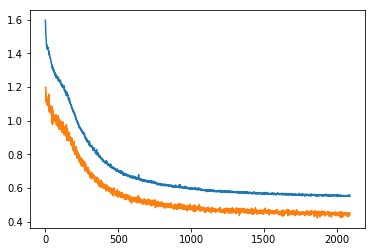

generating audio and Spectrum image
torch.Size([9, 25, 128])
torch.Size([128, 25, 128])
(3200, 2050)


In [27]:
plt.plot(LossOverEpoch)
plt.plot(EvalLoss)
plt.show()
generateAudio('4Beats2Mel','./generatedData3/'+str(Counter))
torch.save(model.cpu().state_dict(), './Demo.model')

In [ ]:
for p in model.parameters():
    print(p.shape)

In [ ]:
model.eval()
outputArray=[]
h0 = torch.zeros(1, 1, 10000).cuda()
c0 = torch.zeros(1, 1, 10000).cuda()
for data, labels in my_testloader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        print(data.shape)
        output,_ = model.forward(data,h0,c0)
        for i in range(SequenceLength):
            outputArray.append(output[i,0,:].cpu().numpy())
outputArray=np.array(outputArray)

In [ ]:
print(outputArray.shape)
plt.imshow(outputArray.T)
plt.tight_layout()

In [ ]:
transformedArray=[]
for elem in outputArray:
    a=np.array(np.int((n_fft/2+1)) *[1+1j])
    a.real=elem[:np.int(n_fft/2+1)]
    a.imag=elem[np.int(n_fft/2+1):]
    transformedArray.append(a)
transformedArray=np.array(transformedArray).T

In [ ]:
print((transformedArray).shape)
Y_infered = librosa.istft(transformedArray,hop_length=hopLength)
ipd.Audio(Y_infered,rate=sr)

In [ ]:
ipd.Audio(y,rate=sr)

In [ ]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(transformedArray.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(tensor_y.numpy()[:,:1025].T,ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


In [ ]:
output=np.array(0);
with torch.no_grad():
        test=torch.zeros([1, 128*windowSize], dtype=torch.float32)
       # test[0][46]=0.0;
        output = model.forward(test)
      #  test2=torch.ones([1, 1025], dtype=torch.float32)
      #  test2[0][46]=0.0;
        loss = criterion(output,torch.zeros([1, 1025], dtype=torch.float32))
        print(loss.item())
print(output.numpy()[0].shape,D_data[250].shape)
plt.plot(output.numpy()[0],'r')
#plt.plot(D_data[250],'g')
plt.show()

In [ ]:
plt.imshow(outPutMidiArray[60].T)
plt.show()

In [ ]:
midiTestArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2Mel.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiTestArray = np.float32(np.array(midiTestArray))
print(midiTestArray.shape)
MainMidiTest=[]
for i in range(midiTestArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiTestArray.shape[0]):
             temp.append(np.zeros(midiTestArray.shape[1]))
        else:
            temp.append(midiTestArray[val])
    MainMidiTest.append(temp)
MainMidiTest=np.array(MainMidiTest)



tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)

testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
TestLoader = utils.DataLoader(testDataSet) # create your dataloader


model.eval()
outputArray=[]
for data, labels in TestLoader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        outputArray.append(output[0].cpu().numpy())
outputArray=np.array(outputArray).T
print((outputArray).shape)
Y_infered2 = librosa.istft(outputArray,hop_length=hopLength) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(midiTestArray.T,interpolation='nearest', aspect='auto')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show();


ipd.Audio(Y_infered2,rate=sr)

In [ ]:
librosa.display.waveplot(y[:500], sr=sr);

In [ ]:
generateAudio('4Beats2Mel','./generatedData/'+str(Counter))

In [ ]:
tensor_x.shape